In [97]:
import tensorflow as tf
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.Session(config=config)

import keras
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import tf as ktf
from keras.callbacks import EarlyStopping
from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import csv
import os
from PIL import Image
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style()

### Data pipeline

In [3]:
%%time
X_train = np.load('data/processed/X_train.npy')
print(X_train.shape)
Y_train = np.load('data/processed/Y_train.npy')
print(Y_train.shape)
X_test = np.load('data/processed/X_test.npy')
print(X_test.shape)

# train_data = np.load('models/bottleneck_features_train.npy')
# validation_data = np.load('models/bottleneck_features_validation.npy')
# test_data = np.load('models/bottleneck_features_test.npy')

(10222, 224, 224, 3)
(10222, 120)
(10357, 224, 224, 3)
CPU times: user 0 ns, sys: 28 s, total: 28 s
Wall time: 59 s


In [2]:
# X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# print(X_train.shape, Y_train.shape)
# # print(X_dev.shape, Y_dev.shape)
# print(X_test.shape)

In [176]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,        
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.2,    
    zoom_range = 0.2,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [178]:
batch_size = 32
img_size = 224

In [179]:
train_generator = train_datagen.flow_from_directory(
    'data/categorical/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')


Found 10222 images belonging to 120 classes.


In [4]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1,)
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(' accuracy')


    plt.subplot(1, 2, 2)
    
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('loss')
    plt.show()

In [141]:
def top_model(input_shape):
    input_img = Input(input_shape)
    X = GlobalAveragePooling2D()(input_img)
#     X = Flatten(input_shape=input_shape)(input_img)
    X = Dropout(0.2)(X)   
    
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(120, activation='softmax')(X)
    
    model = Model(inputs=input_img, outputs=X)
    
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',#optimizers.SGD(lr=1e-4, momentum=0.9),#'adam',
                 metrics=['accuracy'])
    
    return model

### VGG 

In [111]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=1)

In [112]:
type(vgg_model)

keras.engine.training.Model

In [ ]:
vgg_model.ad

In [15]:
# vgg_train_bf = vgg_model.predict(X_train, verbose=1)

In [16]:
# vgg_test_bf = vgg_model.predict(X_test, verbose=1)

In [17]:
# np.save('data/processed/vgg_test_bf.npy', vgg_test_bf)
# np.save('data/processed/vgg_train_bf.npy', vgg_train_bf)

In [18]:
vgg_train_bf = np.load('data/processed/vgg_train_bf.npy')
vgg_test_bf = np.load('data/processed/vgg_test_bf.npy')

In [19]:
vggtop_model = top_model(vgg_train_bf.shape[1:])

In [20]:
vggtop_history = vggtop_model.fit(vgg_train_bf, Y_train, batch_size=100, epochs=30, validation_split=0.2,
                             callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Train on 8177 samples, validate on 2045 samples
Epoch 1/30
8177/8177 [==============================] - 2s 266us/step - loss: 4.8111 - acc: 0.0100 - val_loss: 4.7323 - val_acc: 0.0259
Epoch 2/30
8177/8177 [==============================] - 1s 166us/step - loss: 4.6298 - acc: 0.0223 - val_loss: 4.4421 - val_acc: 0.0313
Epoch 3/30
8177/8177 [==============================] - 1s 164us/step - loss: 4.3709 - acc: 0.0430 - val_loss: 4.1404 - val_acc: 0.0758
Epoch 4/30
8177/8177 [==============================] - 1s 173us/step - loss: 4.1093 - acc: 0.0685 - val_loss: 3.8758 - val_acc: 0.1144
Epoch 5/30
8177/8177 [==============================] - 1s 175us/step - loss: 3.8785 - acc: 0.0948 - val_loss: 3.6674 - val_acc: 0.1345
Epoch 6/30
8177/8177 [==============================] - 1s 175us/step - loss: 3.7393 - acc: 0.1129 - val_loss: 3.5598 - val_acc: 0.1633
Epoch 7/30
8177/8177 [==============================] - 1s 179us/step - loss: 3.5807 - acc: 0.1334 - val_loss: 3.3915 - val_acc: 0.1731


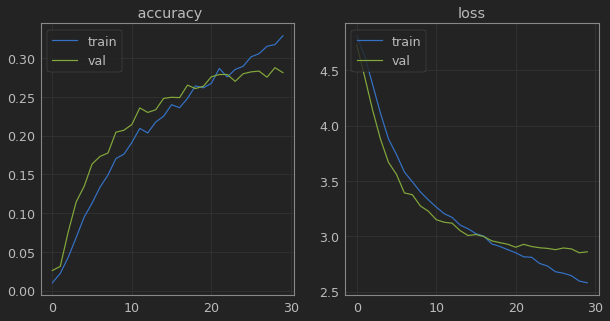

In [21]:
plot_training(vggtop_history)

## ResNet

In [21]:
# base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

In [22]:
# train_bf = base_model.predict(X_train, verbose=1)

10222/10222 [==============================] - 93s 9ms/step


In [111]:
# test_bf = base_model.predict(X_test, verbose=1)

10357/10357 [==============================] - 90s 9ms/step


In [ ]:
# np.save('data/processed/res_test_bf.npy', test_bf)
# np.save('data/processed/res_train_bf.npy', train_bf)

In [22]:
res_train_bf = np.load('data/processed/res_train_bf.npy')
res_test_bf = np.load('data/processed/res_test_bf.npy')

In [23]:
restop_model = top_model(res_train_bf.shape[1:])

In [24]:
restop_history = restop_model.fit(res_train_bf, Y_train, batch_size=100, epochs=30, validation_split=0.2,
                             callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Train on 8177 samples, validate on 2045 samples
Epoch 1/30
8177/8177 [==============================] - 2s 229us/step - loss: 3.7668 - acc: 0.1459 - val_loss: 2.1501 - val_acc: 0.4367
Epoch 2/30
8177/8177 [==============================] - 1s 131us/step - loss: 2.0725 - acc: 0.4223 - val_loss: 1.6639 - val_acc: 0.5359
Epoch 3/30
8177/8177 [==============================] - 1s 119us/step - loss: 1.6267 - acc: 0.5311 - val_loss: 1.4524 - val_acc: 0.5785
Epoch 4/30
8177/8177 [==============================] - 1s 98us/step - loss: 1.3141 - acc: 0.6117 - val_loss: 1.4078 - val_acc: 0.5858
Epoch 5/30
8177/8177 [==============================] - 1s 99us/step - loss: 1.1158 - acc: 0.6683 - val_loss: 1.4004 - val_acc: 0.5858
Epoch 6/30
8177/8177 [==============================] - 1s 103us/step - loss: 0.9577 - acc: 0.7022 - val_loss: 1.3818 - val_acc: 0.6112
Epoch 7/30
8177/8177 [==============================] - 1s 111us/step - loss: 0.8216 - acc: 0.7443 - val_loss: 1.4261 - val_acc: 0.6112
Ep

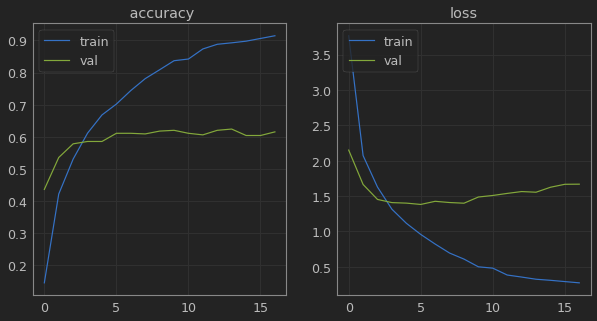

In [25]:
plot_training(restop_history)

## InceptionV3

In [5]:
# inception_model = InceptionV3(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

In [44]:
# inc_train_bf = inception_model.predict(X_train, verbose=1)
# inc_test_bf = inception_model.predict(X_test, verbose=1)

In [167]:
# np.save('data/processed/inc_test_bf.npy', inc_test_bf)
# np.save('data/processed/inc_train_bf.npy', inc_train_bf)

In [6]:
%%time
inc_train_bf = np.load('data/processed/inc_train_bf.npy')
inc_test_bf = np.load('data/processed/inc_test_bf.npy')

In [142]:
inctop_model = top_model(inc_train_bf.shape[1:])

In [143]:
inc_history = inctop_model.fit(inc_train_bf, Y_train, batch_size=100, epochs=20, validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Train on 8177 samples, validate on 2045 samples
Epoch 1/20
8177/8177 [==============================] - 15s 2ms/step - loss: 3.0396 - acc: 0.3405 - val_loss: 1.7169 - val_acc: 0.5868
Epoch 2/20
8177/8177 [==============================] - 3s 409us/step - loss: 1.6226 - acc: 0.5829 - val_loss: 1.4759 - val_acc: 0.6308
Epoch 3/20
8177/8177 [==============================] - 4s 470us/step - loss: 1.2954 - acc: 0.6538 - val_loss: 1.3898 - val_acc: 0.6303
Epoch 4/20
8177/8177 [==============================] - 4s 435us/step - loss: 1.1087 - acc: 0.7015 - val_loss: 1.4380 - val_acc: 0.6328
Epoch 5/20
8177/8177 [==============================] - 3s 415us/step - loss: 0.9649 - acc: 0.7242 - val_loss: 1.3735 - val_acc: 0.6460
Epoch 6/20
8177/8177 [==============================] - 3s 413us/step - loss: 0.8237 - acc: 0.7629 - val_loss: 1.3704 - val_acc: 0.6484
Epoch 7/20
8177/8177 [==============================] - 3s 419us/step - loss: 0.7214 - acc: 0.7856 - val_loss: 1.4345 - val_acc: 0.6323
E

In [162]:
inctop_model.evaluate(inc_train_bf, Y_train)

10222/10222 [==============================] - 3s 340us/step


[0.54008538618966617, 0.8790843279085101]

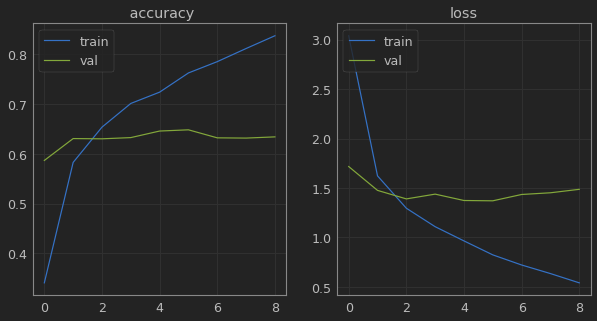

In [144]:
plot_training(inc_history)

In [169]:
inctop_model.save_weights('models/inctop_model.h5')

## Fine tuning

In [181]:
def ft_model(base_model, top_model_weights_path):
    
    top = top_model(base_model.output_shape[1:])
    top.load_weights(top_model_weights_path)
#     x = base_model.predict(X_train)
#     print(top.evaluate(x, Y_train))
    ft_model = Model(inputs=base_model.inputs, outputs=top(base_model.output))
    
    ft_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                 metrics=['accuracy'])
    
    return ft_model
    


In [168]:
inception_model = InceptionV3(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)
for layer in inception_model.layers[:299]:
    layer.trainable = False

In [165]:
# inc_train_bf = inception_model.predict(X_train, verbose=1)

In [175]:
inc_ft_model = ft_model(inception_model, 'models/inctop_model.h5')

10222/10222 [==============================] - 10s 1ms/step
[0.5307638720742085, 0.88153003324993062]


In [166]:
# inc_ft_model.evaluate(X_train, Y_train)

In [115]:
# inc_ft_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

batch_normalization_148 (BatchN (None, 12, 12, 192)  576         conv2d_148[0][0]                 
__________________________________________________________________________________________________
batch_normalization_153 (BatchN (None, 12, 12, 192)  576         conv2d_153[0][0]                 
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, 12, 12, 192)  576         conv2d_154[0][0]                 
__________________________________________________________________________________________________
activation_145 (Activation)     (None, 12, 12, 192)  0           batch_normalization_145[0][0]    
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 12, 12, 192)  0           batch_normalization_148[0][0]    
__________________________________________________________________________________________________
activation

In [171]:
inc_ft_history = inc_ft_model.fit(X_train, Y_train, batch_size=50, epochs=20, validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Train on 8177 samples, validate on 2045 samples
Epoch 1/20
8177/8177 [==============================] - 143s 18ms/step - loss: 0.8345 - acc: 0.7514 - val_loss: 1.2370 - val_acc: 0.7022
Epoch 2/20
8177/8177 [==============================] - 121s 15ms/step - loss: 0.7717 - acc: 0.7707 - val_loss: 1.4023 - val_acc: 0.6538
Epoch 3/20
8177/8177 [==============================] - 121s 15ms/step - loss: 0.7657 - acc: 0.7747 - val_loss: 1.4459 - val_acc: 0.6362
Epoch 4/20
8177/8177 [==============================] - 120s 15ms/step - loss: 0.7305 - acc: 0.7835 - val_loss: 1.4490 - val_acc: 0.6337
Epoch 00004: early stopping


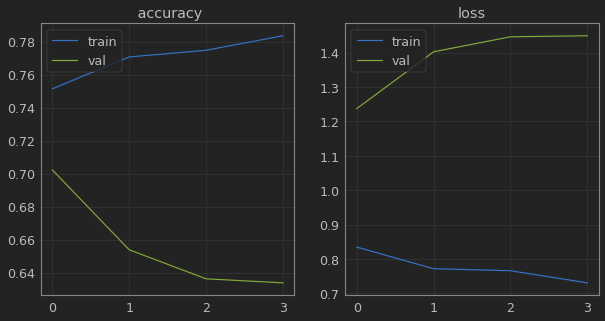

In [172]:
plot_training(inc_ft_history)

In [182]:
inc_ft_model2 = ft_model(inception_model, 'models/inctop_model.h5')

In [185]:
inc_ft_model2.fit_generator(
    train_generator,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=20,
    verbose=1)

Epoch 1/20
319/319 [==============================] - 499s 2s/step - loss: 2.2773 - acc: 0.4579
Epoch 2/20
319/319 [==============================] - 515s 2s/step - loss: 2.1530 - acc: 0.4726
Epoch 3/20
319/319 [==============================] - 496s 2s/step - loss: 2.1300 - acc: 0.4750
Epoch 4/20
319/319 [==============================] - 496s 2s/step - loss: 2.0898 - acc: 0.4821
Epoch 5/20
319/319 [==============================] - 502s 2s/step - loss: 2.0879 - acc: 0.4786
Epoch 6/20
319/319 [==============================] - 499s 2s/step - loss: 2.0640 - acc: 0.4813
Epoch 7/20
 95/319 [=======>......................] - ETA: 6:42 - loss: 2.0514 - acc: 0.4780

KeyboardInterrupt: 

## Prediction

In [157]:
preds = inc_ft_model.predict(X_test, verbose=1, batch_size=16)
df_train = pd.read_csv('labels.csv')
df_test = pd.read_csv('sample_submission.csv')
one_hot = pd.get_dummies(df_train['breed'], sparse = True)

sub = pd.DataFrame(preds)
sub.columns = one_hot.columns.values
sub.insert(0, 'id', df_test['id'])

sub.to_csv('sub.csv', index=False)

10357/10357 [==============================] - 70s 7ms/step
